In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt
import matplotlib as mpl
from pylab import rcParams
from scipy import integrate
from typing import List,Tuple

cache = {}
res_folder = 'C:\\Users\\alexandr.pankratov\\bashkirtseva\\pattern_stat_06_04_2020'

## Patterns

In [2]:
def make_tex_label(source_label):
    newlabels = source_label.split('BREAK')
    return '${0}$\n${1}$'.format(
        newlabels[0].replace('down','\\downarrow').replace('up','\\uparrow'), 
        newlabels[1].replace('down','\\downarrow').replace('up','\\uparrow'))

def postprocess_labels_for_grouping_plot(axes, labels):
    labels = list(map(make_tex_label,labels))
    axes.set_xticklabels(labels,rotation = 1)
    axes.legend(['fraction of\nend pattern'])

def load_meta(path):
    curr=''
    with open(path) as inp:
        curr = json.load(inp)
    curr['init_pattern'] = np.fromstring(re.sub('[\\s]+', ' ',curr['init_pattern'][1:-1]), dtype=np.float, sep=' ')
    curr['end_pattern'] = np.fromstring(re.sub('[\\s]+', ' ',curr['end_pattern'][1:-1]), dtype=np.float, sep=' ')
    return curr    

def draw_data(xs,data_start,data_end,label):
    plt.plot(xs,data_start,color='#117733',linewidth=5, label = 'Начальные\nусловия')
    plt.plot(xs,data_end,color='#FF5555',linewidth=9,label = 'Итоговый\nпаттерн')
    y_ticks = plt.yticks()[0]
    y_labels = [' ']+[str(i)[:3] for i in y_ticks[1:-1]]+['${0}$'.format(label)]
    x_ticks = plt.xticks()[0][1:-1]
    x_labels = [str(i) for i in x_ticks[:-1]]+['$x$']
    plt.xticks(ticks = x_ticks,labels = x_labels)
    plt.yticks(ticks = y_ticks,labels = y_labels)
    plt.legend(loc='upper right')
    plt.show()

def draw_meta(path):
    meta = load_meta(path)
    print(meta['params'],meta['init'])
    xs = np.array([i*meta['params']['dx'] for i in range(meta['init']['points_count'])])
    draw_data(xs,meta['init_pattern'][::2],meta['end_pattern'][::2],'U')
    draw_data(xs,meta['init_pattern'][1::2],meta['end_pattern'][1::2],'V')
    return meta

## Heatmap

In [3]:
def set_matplotlib_for_grouping_plot():
    rcParams['figure.figsize'] = 20,10
    rcParams['legend.fontsize'] = 22
    rcParams['axes.titlesize'] = 20
    rcParams['xtick.labelsize'] = 22
    rcParams['ytick.labelsize'] = 22
    rcParams['grid.color'] = 'black'
    rcParams['axes.grid'] = True

set_matplotlib_for_grouping_plot()
    
def make_tex_label(source_label):
    newlabels = source_label.split('BREAK')
    return '${0}$\n${1}$'.format(
        newlabels[0].replace(' down','\\downarrow').replace(' up','\\uparrow'), 
        newlabels[1].replace(' down','\\downarrow').replace(' up','\\uparrow'))
def postprocess_labels_for_grouping_plot(ax, labels,title=''):
    labels = list(map(make_tex_label,labels))
    ax.set_xticklabels(labels,rotation = 1)
    ax.set_xlabel('')
    ax.set_title(title)
    ax.legend(['Доля от общего\nчисла паттернов'])

In [4]:
def calc_all_stat(df, suffix, du):
    pc = df['points_count'].unique()
    assert 200 in pc or 400 in pc and len(pc)<=2
    df_200 = df[(df['points_count']==200)]
    df_400 = df[(df['points_count']==400)]
    df_200_cos = df[(df['points_count']==200)&(df['pattern_type']=='cos')]
    df_200_rand = df[(df['points_count']==200)&(df['pattern_type']=='rand')]
    df_400_cos = df[(df['points_count']==400)&(df['pattern_type']=='cos')]
    df_400_rand = df[(df['points_count']==400)&(df['pattern_type']=='rand')]
    calc_stat(df_200_cos, suffix+'; cos; x: [0, 40]', du+', $x \in [0, 40]$')
    calc_stat(df_400_cos, suffix+'; cos; x: [0, 80]', du+', $x \in [0, 80]$')
    calc_stat(df_200_rand, suffix+'; rand; x: [0, 40]', du+', $x \in [0, 40]$')
    calc_stat(df_400_rand, suffix+'; rand; x: [0, 80]', du+', $x \in [0, 80]$')
    calc_stat(df_200, suffix+'; cos and rand; x: [0, 40]', du+', $x \in [0, 40]$')
    calc_stat(df_400, suffix+'; cos and rand; x: [0, 80]', du+', $x \in [0, 80]$')

def calc_stat(df, suffix, du):
    if len(df)==0:
        return
    df[suffix] = 'u: '+df['picks_res_u'].astype(str)+' '+df['direction_res_u'] + 'BREAKv: '+ df['picks_res_v'].astype(str)+' '+df['direction_res_v']
    grouped = df.groupby([suffix])[[suffix]].agg('count')
    grouped[suffix] = grouped[suffix]/grouped[suffix].sum()
    axes = grouped.plot(kind='bar', grid = True,label='')
    postprocess_labels_for_grouping_plot(axes,  grouped.index, du)
    plt.savefig(os.path.join(res_folder, suffix.replace(':','')+' pattern_frac.png'))
    print(suffix)
    plt.show()
    

In [5]:
def _draw_heatmap_internal(data,cmap,dx,dt,x_min):
    ax = sns.heatmap(data,cmap=cmap)
    ys = np.linspace(0,data.shape[0],9)
    ax.set_yticks(ys)
    y_labels = ['$x$']+[str(i) for i in (ys*dx)[::-1]][1:-1]
    ax.set_yticklabels(y_labels)
    xs = np.linspace(0,data.shape[1],11)
    ax.set_xticks(xs)
    x_labels = [str((i+x_min)*dt) for i in xs][:-1]+['$t$']
    ax.set_xticklabels(x_labels, rotation=1)
    plt.show()
    return data

def draw_heatmap(folder,dt,dx,cmap='Spectral',x_min=None,x_max=None):
    if folder not in cache:
        data = np.loadtxt(os.path.join(folder,'process'),dtype=np.float,delimiter=',')
        cache[folder]=data
    else:
        data = cache[folder]
    max_time = data.shape[0]*dt
    if x_min is None:
        x_min = 0
    x_min = int(x_min/dt) 
    if x_max is None:
        x_max = max_time
    x_max = int(x_max/dt)
    u = _draw_heatmap_internal(data[:,::2][x_min:x_max].T,cmap,dx,dt,x_min)
    v = _draw_heatmap_internal(data[:,1::2][x_min:x_max].T,cmap,dx,dt,x_min)
    return(u,v)

def fourier_coeff_process(folder, k, dx, var = 'u', tmax=None, dt=None):
    assert tmax is None or tmax is not None and dt is not None  
    if folder not in cache:
        data = np.loadtxt(os.path.join(folder,'process'),dtype=np.float,delimiter=',')
        cache[folder]=data
    else:
        data = cache[folder]
    if tmax is None:
        tmax = data.shape[0]
    else:
        tmax = int(tmax/dt)
    xmax = int(data.shape[1]/2)*dx
    if var == 'u':
        data = data[:tmax,::2]
    else:
        data = data[:tmax,1::2]
    cos = np.cos(np.arange(0,xmax,dx)*2*np.pi*k/xmax)
    return np.apply_along_axis(lambda x: integrate.simps(cos*x,dx=dx),1,data)

def fourier_cos_pattern(data: np.ndarray, k: float, dx:float):
    cos = np.cos(np.linspace(0,1,len(data))*2*np.pi*k)
    return integrate.simps(cos*data,dx=dx)

def draw_fourier_coeffs(folder, ks, dx, tmax, dt):
    xs = np.arange(0, tmax, dt)
    set_matplotlib_for_grouping_plot()
    for k in ks:
        fr = fourier_coeff(folder, k, 0.2, 'u', tmax, dt)
        ax = plt.plot(np.arange(0,tmax,0.1), fr, label='$C_{{{0}}}$'.format(k),linewidth=3)
    plt.legend(loc='upper right')
    xticks = plt.xticks()[0][1:-1]
    plt.xticks(ticks=xticks, labels=list(xticks[:-1])+['$t$'])
    yticks = plt.yticks()[0][1:]
    plt.yticks(ticks=yticks, labels=[str(i)[:3] for i in (list(yticks[:-1])+['$C$'])])
    plt.show()
    for k in ks:
        fr = fourier_coeff(folder, k, 0.2, 'v', tmax, dt)
        plt.plot(np.arange(0,tmax,0.1), fr, label='$C_{{{0}}}$'.format(k),linewidth=3)
    xticks = plt.xticks()[0][1:-1]
    plt.xticks(ticks=xticks, labels=list(xticks[:-1])+['$t$'])
    yticks = plt.yticks()[0][1:]
    plt.yticks(ticks=yticks, labels=[str(i)[:3] for i in (list(yticks[:-1])+['$C$'])])
    plt.legend(loc='upper right')
    plt.show()
    
def draw_process_if_exists(path: str, time_points: List[Tuple[float,float]], dt: float, dx: float):
    res = []
    if os.path.isfile(os.path.join(path,'process')):
        print(path)
        for t in time_points:
            draw_meta(os.path.join(path,'meta.json'))
            res.append(draw_heatmap(path, dt=dt,dx=dx,x_min = t[0], x_max=t[1]))
        return res

## Analyze

In [6]:
def try_proof_period2D(data: np.ndarray, eps = 0.01):
    deltas = np.apply_along_axis(np.max,0,np.abs(data[:,10:] - data[:,0].reshape(data.shape[0],1)))
    plt.plot(np.linspace(0,1,len(deltas)), deltas)
    plt.show()
    fig, ax = plt.subplots()
    plt.plot(np.linspace(0,1,len(deltas)), deltas)
    ax.set_yscale('log')
    plt.show()

def try_get_pattern_type(data: np.ndarray, window = 10, eps = 0.0001):
    deltas = np.abs(data[1::]-data[0])
    since_last_match = 0
    matches = 0
    for index, d in enumerate(deltas):
        if d < eps and index >= window and index < (len(deltas) - window) and (np.sign(d - deltas[index-window])==np.sign(d - deltas[index + window])):
            matches+=1
            since_last_match = 0
        else:
            since_last_match +=1
    if matches > 30:
        return 'b', matches
    if matches <=1:
        return 'r', matches
    return 'g', matches

In [7]:
data = pd.read_csv('C:\\Users\\alexandr.pankratov\\bashkirtseva\\pattern_stat_07_04_2020_small_noise\\_res_2020-04-07 09_51_07.806171',sep=',')

In [8]:
data.drop('Unnamed: 0',axis=1, inplace=True)


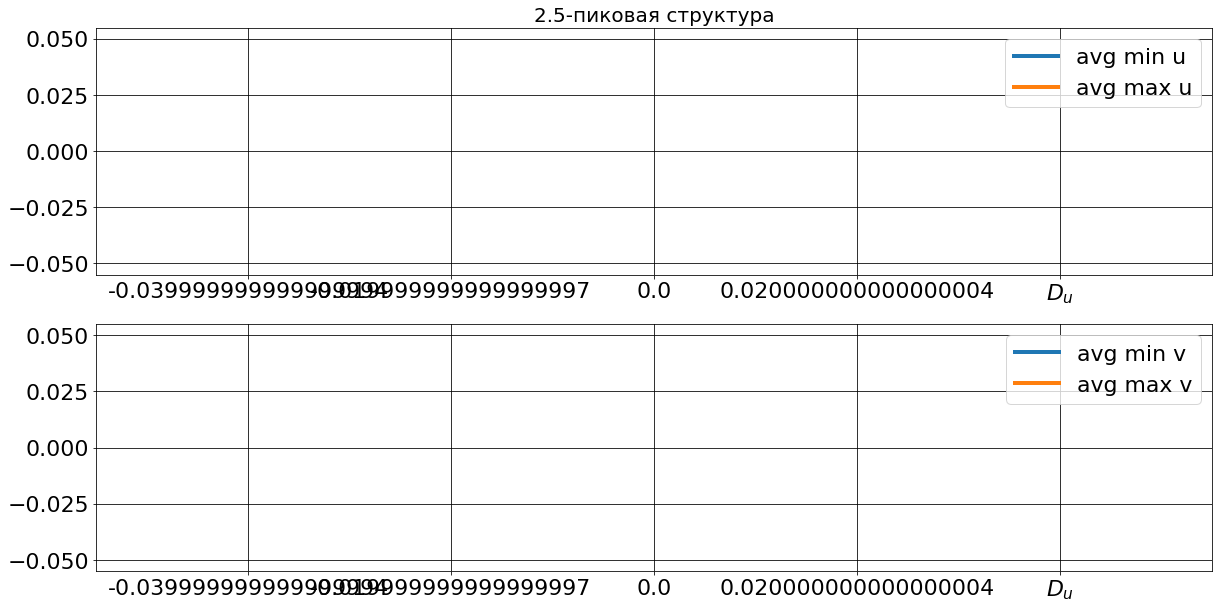

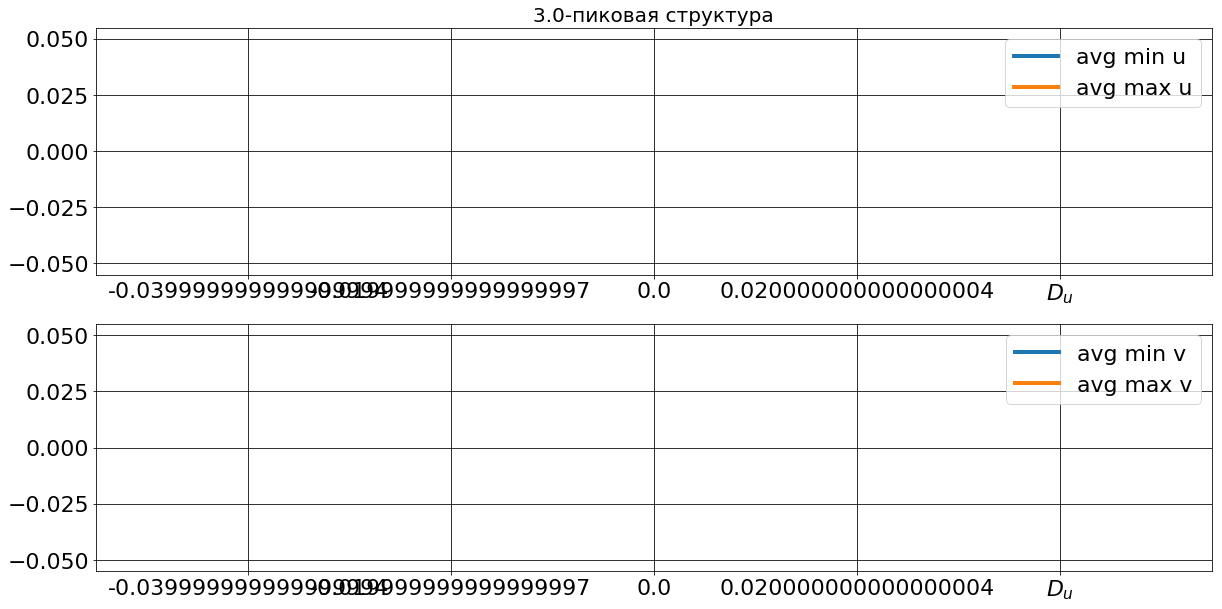

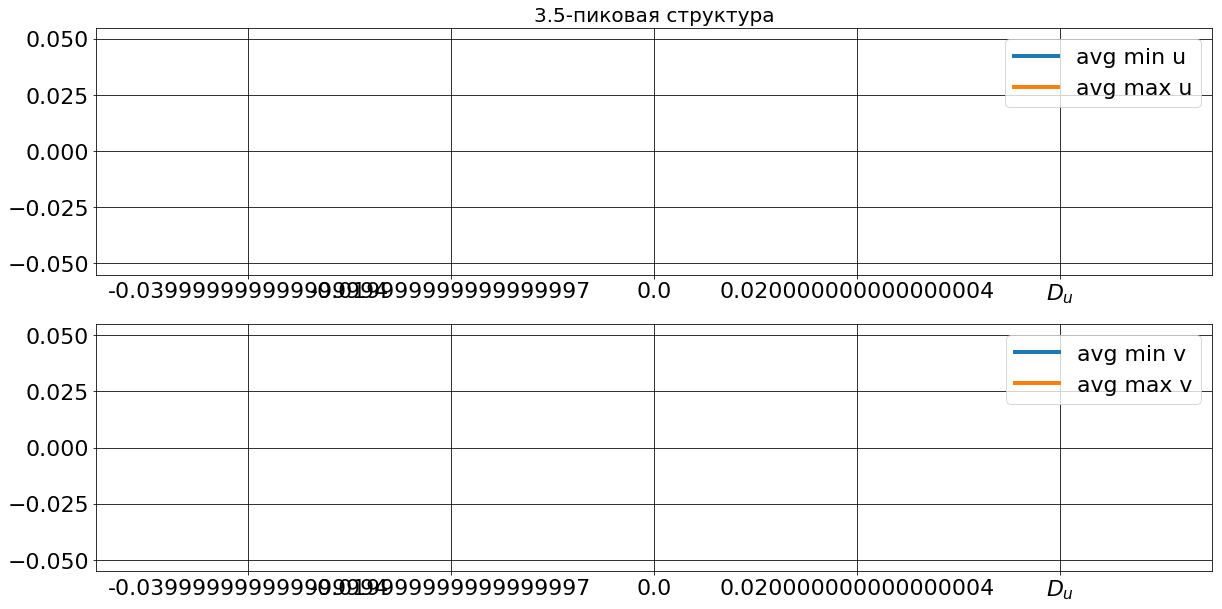

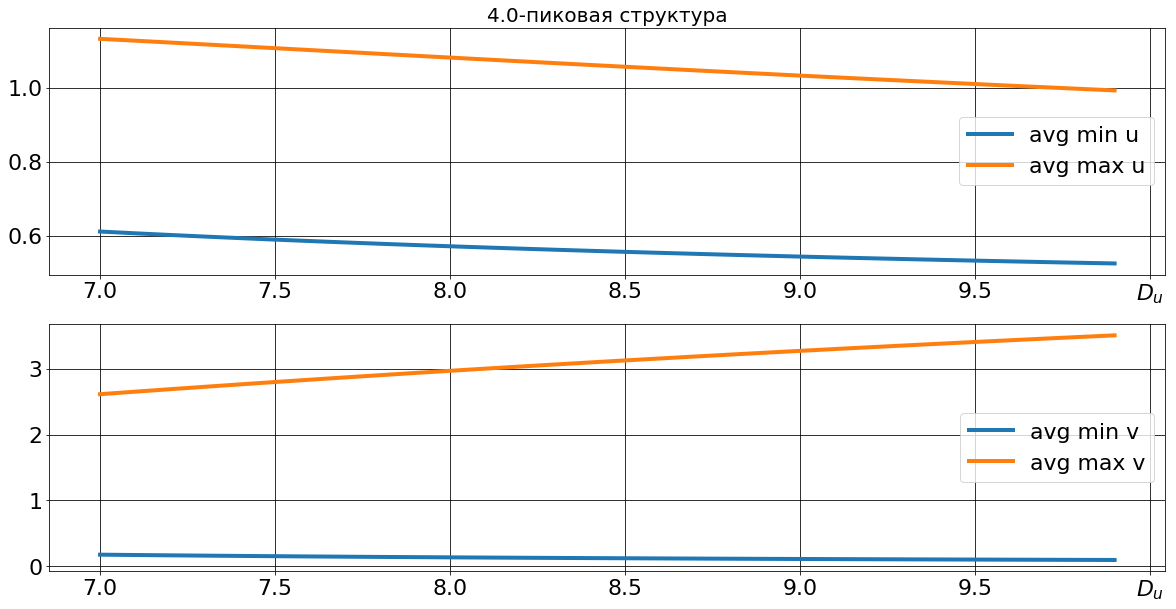

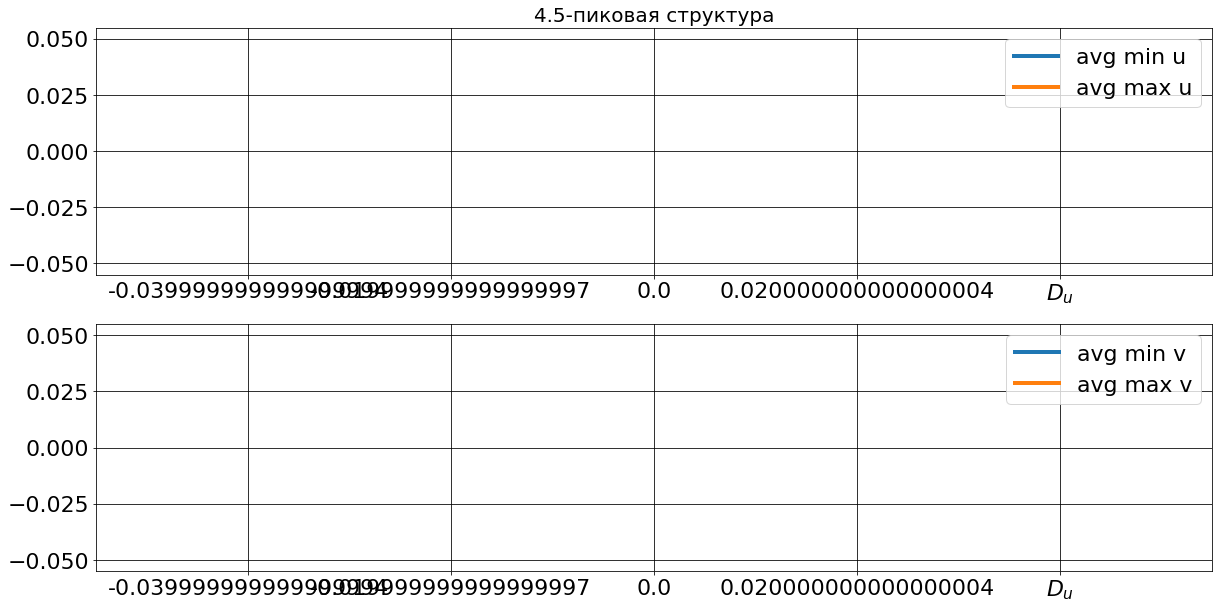

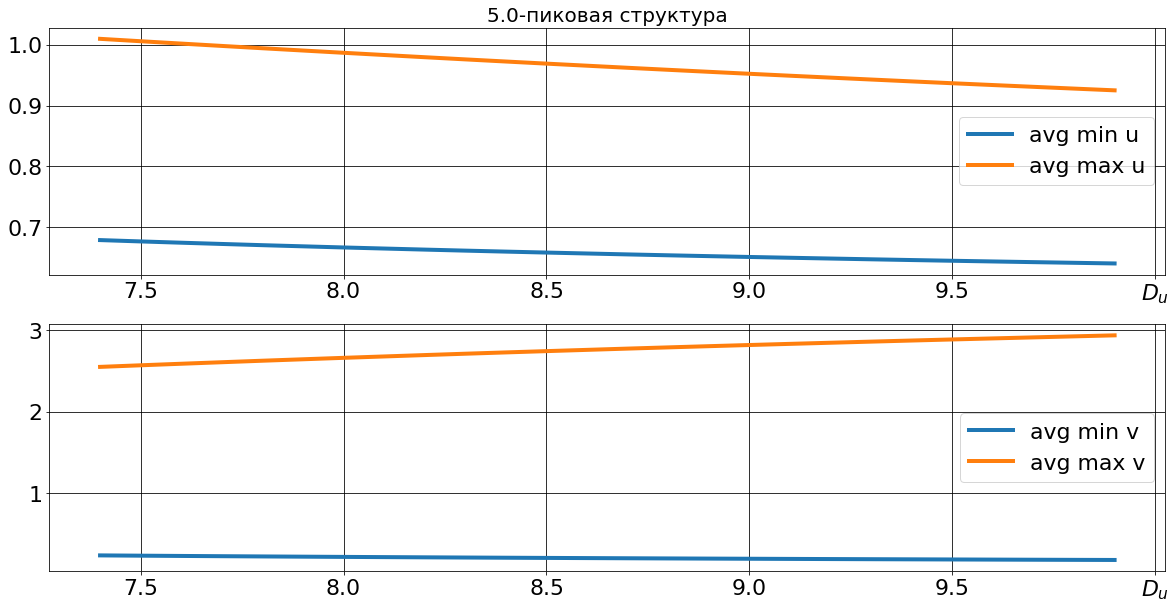

In [9]:
#for du in np.arange(7,20.5,0.5):
#    df_du = data[(data['Du']==du)]
#    calc_stat(df_du,'','$D_u = '+str(du)+'$')
#    print(df_du.shape)

for i in np.arange(2.5,5.5,0.5):
    sas = data[(data['picks_res_u']==i)]
    grouped = sas.groupby(sas['Du'], as_index=True, sort=True, group_keys=True)
    #print(i, grouped.groups.keys(), grouped['res_u_min'].mean(), grouped['res_u_max'].mean())
    figs,axes = plt.subplots(2,1)
    axes[0].plot(list(grouped.groups.keys()), list(grouped['res_u_min'].mean()),label='avg min u',linewidth = 4)
    axes[0].plot(list(grouped.groups.keys()), list(grouped['res_u_max'].mean()),label='avg max u',linewidth = 4)
    axes[0].grid(True)
    axes[0].set_title('{0}-пиковая структура'.format(i))
    axes[0].legend()
    xlabels = axes[0].get_xticks().astype(str)
    xlabels[-2]='$D_u$'
    axes[0].set_xticklabels(xlabels)
    axes[1].plot(list(grouped.groups.keys()), list(grouped['res_v_min'].mean()),label='avg min v',linewidth = 4)
    axes[1].plot(list(grouped.groups.keys()), list(grouped['res_v_max'].mean()),label='avg max v',linewidth = 4)
    axes[1].grid(True)
    xlabels = axes[1].get_xticks().astype(str)
    xlabels[-2]='$D_u$'
    axes[1].set_xticklabels(xlabels)
    axes[1].legend()
    plt.show()
    

In [167]:
data[(data['picks_res_u']==3.5)][['res']].head(100)


,folder,pattern_type,amp,points_count,picks_count,p,q,Du,Dv,dx,...,transient save step,max_time,res_u_min,res_u_max,res_v_min,res_v_max,picks_res_u,direction_res_u,picks_res_v,direction_res_v
1,C:\Users\alexandr.pankratov\bashkirtseva\distr...,rand,0.1,200,0,3,1,10.0,1,0.2,...,0.1,1300.0,0.498732,1.076780,0.075056,3.446938,3.5,up,3.5,down
3,C:\Users\alexandr.pankratov\bashkirtseva\distr...,rand,0.1,200,0,3,1,10.0,1,0.2,...,0.1,1300.0,0.498732,1.076780,0.075056,3.446938,3.5,up,3.5,down
8,C:\Users\alexandr.pankratov\bashkirtseva\distr...,rand,0.1,200,0,3,1,10.0,1,0.2,...,0.1,1300.0,0.498732,1.076780,0.075056,3.446938,3.5,down,3.5,up
10,C:\Users\alexandr.pankratov\bashkirtseva\distr...,rand,0.1,200,0,3,1,10.0,1,0.2,...,0.1,1300.0,0.498732,1.076780,0.075056,3.446938,3.5,down,3.5,up
12,C:\Users\alexandr.pankratov\bashkirtseva\distr...,rand,0.1,200,0,3,1,10.0,1,0.2,...,0.1,1200.0,0.498732,1.076780,0.075056,3.446938,3.5,up,3.5,down
13,C:\Users\alexandr.pankratov\bashkirtseva\distr...,rand,0.1,200,0,3,1,10.0,1,0.2,...,0.1,1300.0,0.498732,1.076780,0.075056,3.446938,3.5,down,3.5,up
16,C:\Users\alexandr.pankratov\bashkirtseva\distr...,rand,0.1,200,0,3,1,10.0,1,0.2,...,0.1,1300.0,0.498732,1.076780,0.075056,3.446938,3.5,down,3.5,up
21,C:\Users\alexandr.pankratov\bashkirtseva\distr...,rand,0.1,200,0,3,1,10.0,1,0.2,...,0.1,1300.0,0.498732,1.076780,0.075056,3.446938,3.5,down,3.5,up
28,C:\Users\alexandr.pankratov\bashkirtseva\distr...,rand,0.1,200,0,3,1,10.0,1,0.2,...,0.1,1200.0,0.498732,1.076780,0.075056,3.446938,3.5,up,3.5,down
29,C:\Users\alexandr.pankratov\bashkirtseva\distr...,rand,0.1,200,0,3,1,10.0,1,0.2,...,0.1,1200.0,0.498732,1.076780,0.075056,3.446938,3.5,up,3.5,down


C:\Users\alexandr.pankratov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


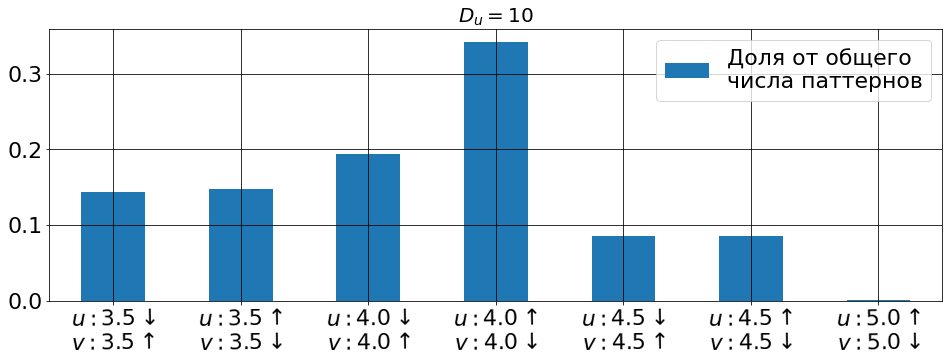

In [117]:
calc_stat(df_10,'','$D_u = 10$')

C:\Users\alexandr.pankratov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


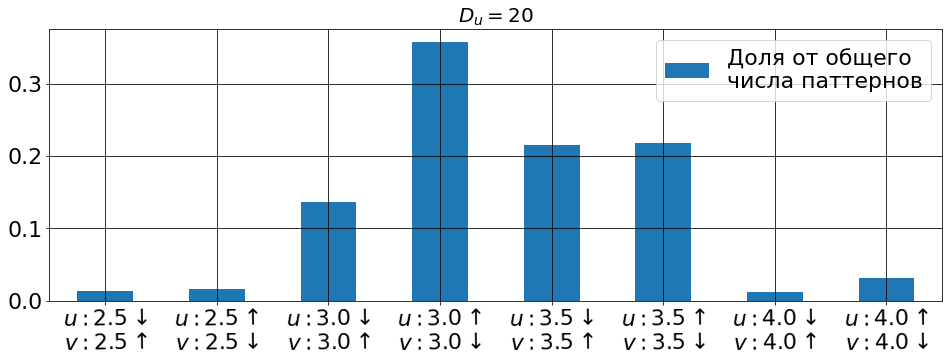

In [118]:
calc_stat(df_20,'','$D_u = 20$')